<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_after_discussion_no_duration_feature_select.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特徵選擇
- 用 XGBClassifier 進行特特徵選擇，並重新訓練。
- 選出的特徵: ['poutcome', 'housing', 'job', 'pdays', 'education', 'loan', 'marital', 'previous', 'campaign', 'balance']


In [ ]:
!pip install gradio

In [2]:
import gradio as gr

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb
import os

import joblib


In [12]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [13]:
df = data.copy()

# 刪除 duration
df = df.drop(columns=["duration"])

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [14]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [15]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [22]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


,col_name,dtype,isna,unique_num,min,max,unique_20
0,poutcome,object,False,3,failure,success,"[failure, other, success]"
1,housing,int64,False,2,0,1,"[0, 1]"
2,job,object,False,11,admin.,unemployed,"[admin., services, management, blue-collar, te..."
3,pdays,int64,False,525,1,871,"[151, 91, 86, 143, 89, 140, 176, 174, 167, 195..."
4,education,object,False,3,primary,tertiary,"[tertiary, secondary, primary]"
5,loan,int64,False,2,0,1,"[0, 1]"
6,marital,object,False,3,divorced,single,"[married, single, divorced]"
7,previous,int64,False,39,1,275,"[3, 4, 2, 1, 16, 6, 5, 10, 12, 7, 18, 9, 8, 11..."
8,campaign,int64,False,16,1,16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10, 14, 12, 15..."
9,balance,int64,False,2764,0,81204,"[882, 3444, 2415, 0, 1324, 172, 3132, 1005, 87..."


In [17]:
# 特徵選擇
# ['poutcome', 'housing', job, 'pdays', 'education', 'loan', 'marital', 'previous', 'campaign', 'balance']

df = df[['poutcome', 'housing', 'job', 'pdays', 'education', 'loan', 'marital', 'previous', 'campaign', 'balance', 'y']]
df.shape


(7371, 11)

In [18]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [21]:
# 二元特徵及目標變數編碼
ordinal_features = ["housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})



In [23]:
# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)


(7371, 10) (7371,)


In [24]:
# 切分訓練組、驗證組、測試組

# 切出測試集(保留最後評估用)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# 剩下的資料切成訓練、驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_temp)
display(X_temp.shape, y_temp.shape)
display(X_test.shape, y_test.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
print(X_val.index.equals(y_val.index))


(5896, 10)

(5896,)

(1475, 10)

(1475,)

(4422, 10)

(4422,)

(1474, 10)

(1474,)

True
True
True


In [27]:
display(df.dtypes.value_counts())
display(df.select_dtypes(include=["int64"]).columns)
display(df.select_dtypes(include=["object"]).columns)

,count
int64,7
object,4


Index(['housing', 'pdays', 'loan', 'previous', 'campaign', 'balance', 'y'], dtype='object')

Index(['poutcome', 'job', 'education', 'marital'], dtype='object')

In [28]:
# 欄位分類
# ['poutcome', 'housing', job, 'pdays', 'education', 'loan', 'marital', 'previous', 'campaign', 'balance']



int_columns = ['pdays', 'previous', 'campaign', 'balance'] # 數值型欄位，做標準化縮放
ordinal_columns = ["education"] # 類別型欄位，做標籤編碼
binary_columns = ["housing", "loan"] # ["yes", ""no] 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns


10


In [29]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    #['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])


In [30]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_val_preproceed = preprocessor.transform(X_val) # 驗證組預處理

# 儲存預處理器
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [31]:
# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_val_preproceed = pd.DataFrame(X_val_preproceed, columns=all_preprocessed_columns, index=X_val.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_val_preproceed.shape, y_val.shape)

display(X_train_preproceed.head(3))
display(X_val_preproceed.head(3))


(4422, 24)

(4422,)

(1474, 24)

(1474,)

,pdays,previous,campaign,balance,education,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
35777,1.319633,-0.223202,-0.678116,-0.435792,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40885,-1.024494,-0.409674,-0.678116,0.210741,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
37975,1.194375,-0.409674,-0.042948,-0.441751,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,pdays,previous,campaign,balance,education,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
41264,-0.228206,-0.409674,-0.678116,-0.468864,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43930,-1.069229,-0.223202,1.227388,-0.506702,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34928,0.433875,0.149743,-0.678116,-0.260305,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [32]:
# 訓練模型

model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
              max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
              subsample=1, reg_alpha=0.1, reg_lambda=100)

model.fit(X_train_preproceed, y_train)

# 將模型存檔
joblib.dump(model, "model.pkl")



['model.pkl']

In [35]:
y_train_score = model.predict_proba(X_train_preproceed)[:, 1]
threshold = 0.53 # f1-score 最大
y_train_pred = (y_train_score >= threshold).astype(float)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"train accuracy: {train_accuracy}")
print(train_report)

print("-" * 30 )

y_val_score = model.predict_proba(X_val_preproceed)[:, 1]
y_val_pred = (y_val_score >= threshold).astype(float)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
print(f"val accuracy: {val_accuracy}")
print(val_report)




train accuracy: 0.8170511080958842
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3373
           1       0.60      0.68      0.64      1049

    accuracy                           0.82      4422
   macro avg       0.75      0.77      0.76      4422
weighted avg       0.83      0.82      0.82      4422

------------------------------
val accuracy: 0.8208955223880597
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1124
           1       0.61      0.66      0.64       350

    accuracy                           0.82      1474
   macro avg       0.75      0.77      0.76      1474
weighted avg       0.83      0.82      0.82      1474



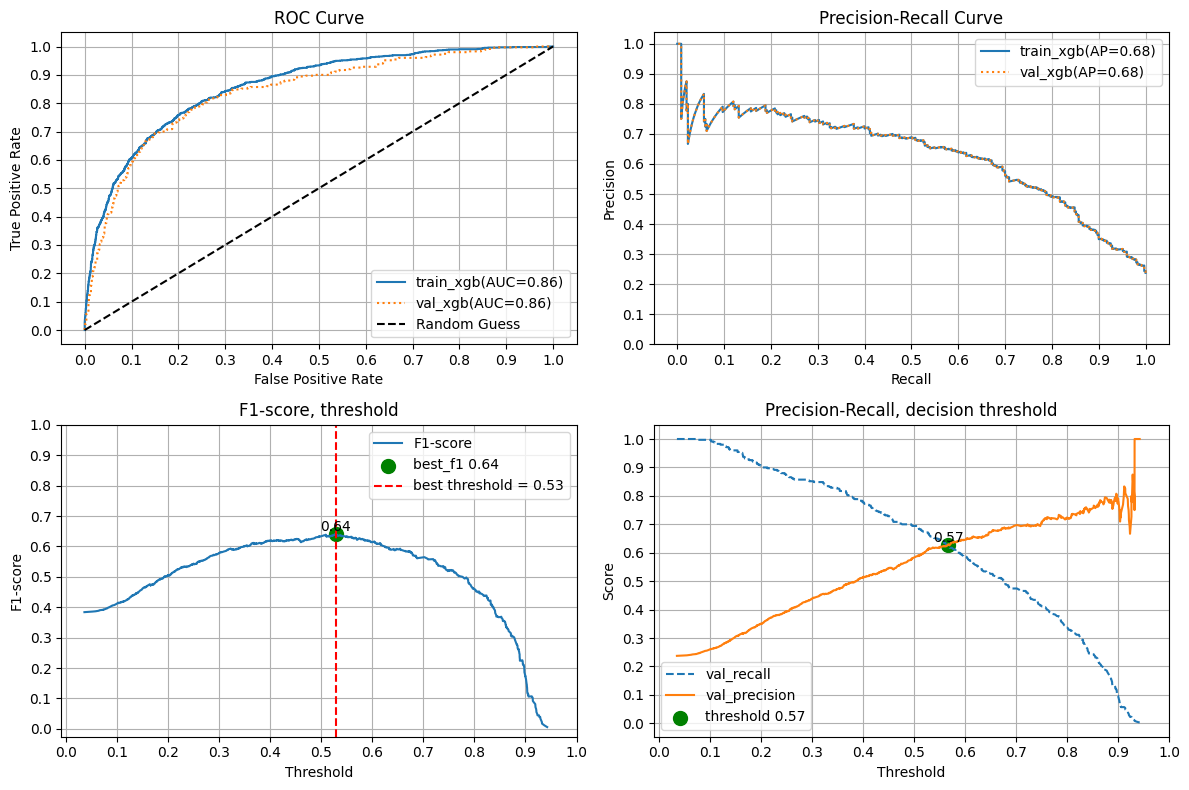

In [34]:
# 畫圖確認特徵選擇完後訓練組和驗證組的 roc, pr 的狀況。
# 畫圖找出決策門檻值

# 生成子圖 (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten() # 將子圖展平

# 畫 train, val 的 ROC-AUC, PR-AP curve

# 畫 Train, val 的 ROC-AUC
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_score)
train_roc_auc = auc(train_fpr, train_tpr)
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_score)
val_roc_auc = auc(val_fpr, val_tpr)

ax[0].plot(train_fpr, train_tpr, label=f"train_xgb(AUC={train_roc_auc:.2f})")
ax[0].plot(val_fpr, val_tpr, ":", label=f"val_xgb(AUC={train_roc_auc:.2f})")

ax[0].plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[0].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[0].set_title("ROC Curve")
ax[0].legend()
ax[0].grid(True)


# 畫 Train, val 的 PR-AP
train_precisions, train_recalls, train_thresholds = precision_recall_curve(y_val, y_val_score)
train_ap_score = average_precision_score(y_train, y_train_score)
val_precisions, val_recalls, val_thresholds = precision_recall_curve(y_val, y_val_score)
val_ap_score = average_precision_score(y_train, y_train_score)

ax[1].plot(train_recalls, train_precisions, label=f"train_xgb(AP={train_ap_score:.2f})")
ax[1].plot(val_recalls, val_precisions, ":", label=f"val_xgb(AP={val_ap_score:.2f})")

ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[1].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()
ax[1].grid(True)

# 畫 F1-score-Threshold
f1s = 2 * (val_precisions * val_recalls) / (val_precisions + val_recalls + 1e-8)
best_idx = np.argmax(f1s)
best_threshold = val_thresholds[best_idx]
best_f1 = f1s[best_idx]

ax[2].plot(val_thresholds, f1s[ : -1], label='F1-score')
ax[2].scatter(best_threshold, best_f1, color="green", s=100, label=f"best_f1 {best_f1:.2f}")
ax[2].axvline(x=best_threshold, color='red', linestyle='--', label=f'best threshold = {best_threshold:.2f}')
ax[2].text(best_threshold, best_f1, f"{best_f1:.2f}", ha="center", va="bottom")

ax[2].set_xlabel("Threshold")
ax[2].set_ylabel("F1-score")
ax[2].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[2].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[2].set_title("F1-score, threshold")
ax[2].legend()
ax[2].grid(True)


# 畫 Presion-recall-threshold
ax[3].plot(val_thresholds, val_recalls[ : -1], "--", label="val_recall")
ax[3].plot(val_thresholds, val_precisions[ : -1], label="val_precision")

threshold_idx = np.argmin(abs(val_precisions - val_recalls))
cross_threshold = val_thresholds[threshold_idx]
ax[3].scatter(cross_threshold, val_precisions[threshold_idx], color="green", s=100, label=f"threshold {cross_threshold:.2f}")
ax[3].text(cross_threshold, val_precisions[threshold_idx], f"{cross_threshold:.2f}", ha="center", va="bottom")

ax[3].set_xlabel("Threshold")
ax[3].set_ylabel("Score")
ax[3].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[3].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[3].set_title("Precision-Recall, decision threshold")
ax[3].legend()
ax[3].grid(True)




plt.tight_layout()





In [36]:
# 合併訓練組、驗證組

X_train_val_preproceed = pd.concat([X_train_preproceed, X_val_preproceed], axis=0)
y_train_val_preproceed = pd.concat([y_train, y_val], axis=0)

display(X_train_preproceed.shape, X_val_preproceed.shape)
display(X_train_val_preproceed.shape, y_train_val_preproceed.shape)





(4422, 24)

(1474, 24)

(5896, 24)

(5896,)

In [37]:
# 合併後重新訓練，得到 final model

model_final = model.fit(X_train_val_preproceed, y_train_val_preproceed)
joblib.dump(model_final, "model_final.pkl")


['model_final.pkl']

In [38]:
# 對測試組進行預處理

X_test_preproceed = preprocessor.transform(X_test)
X_test_preproceed = pd.DataFrame(X_test_preproceed, columns=all_preprocessed_columns, index=X_test.index) # 測試組重新生成dataframe
display(X_test_preproceed.index.equals(X_test.index))

display(X_test.shape, y_test.shape)
display(X_test_preproceed.shape, y_test.shape)



True

(1475, 10)

(1475,)

(1475, 24)

(1475,)

test accuracy: 0.8183050847457627
test ROC_AUC: 0.8375504761904763
test PR_AP: 0.644120108366958
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1125
           1       0.61      0.67      0.64       350

    accuracy                           0.82      1475
   macro avg       0.75      0.77      0.76      1475
weighted avg       0.83      0.82      0.82      1475



<Axes: >

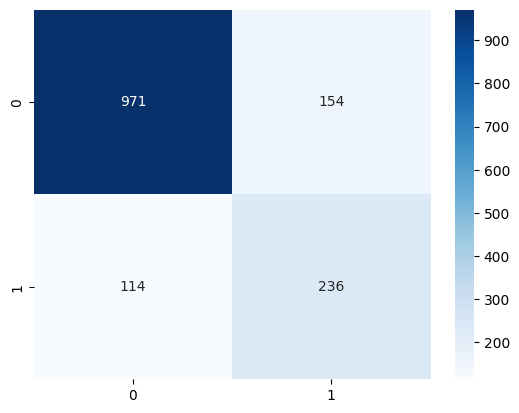

In [49]:
# 對測試組進行預測，產生報告。
# threshold 參照找出來的決策門檻值， 0.53 (f1-score 最大)

y_test_score = model.predict_proba(X_test_preproceed)[:, 1]
y_test_pred = (y_test_score >= threshold).astype(float)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)


test_fpr, test_tpr, _ = roc_curve(y_test, y_test_score)
test_roc_auc = auc(test_fpr, test_tpr)

test_precisions, test_recalls, _ = precision_recall_curve(y_test, y_test_score)
test_ap_score = average_precision_score(y_test, y_test_score)

print(f"test accuracy: {test_accuracy}")
print(f"test ROC_AUC: {test_roc_auc}")
print(f"test PR_AP: {test_ap_score}")
print(test_report)

sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")



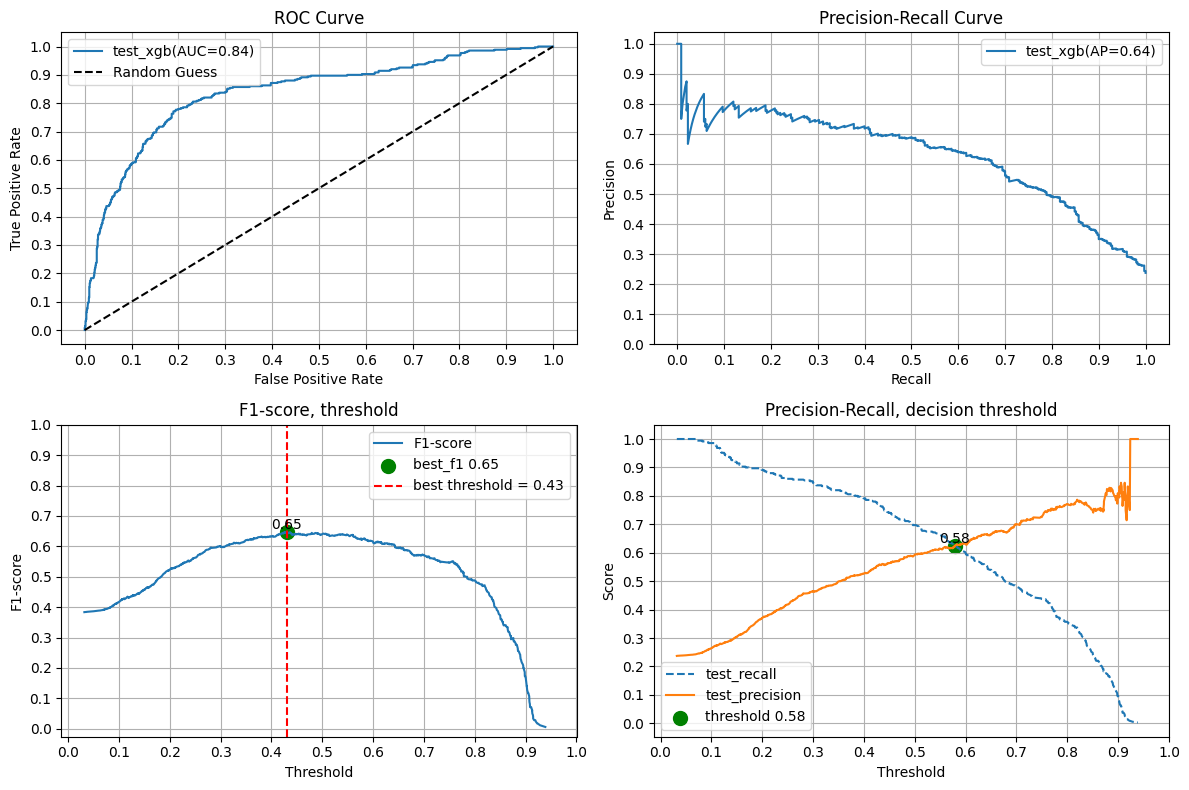

In [46]:
# 畫圖確認特徵選擇完後訓練組和驗證組的 roc, pr 的狀況。
# 畫圖找出決策門檻值

# 生成子圖 (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten() # 將子圖展平

# 畫 train, val 的 ROC-AUC, PR-AP curve

# 畫 Train, val 的 ROC-AUC
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_score)
test_roc_auc = auc(test_fpr, test_tpr)

ax[0].plot(test_fpr, test_tpr, label=f"test_xgb(AUC={test_roc_auc:.2f})")

ax[0].plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[0].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[0].set_title("ROC Curve")
ax[0].legend()
ax[0].grid(True)


# 畫 Train, val 的 PR-AP
test_precisions, test_recalls, test_thresholds = precision_recall_curve(y_test, y_test_score)
test_ap_score = average_precision_score(y_test, y_test_score)


ax[1].plot(train_recalls, train_precisions, label=f"test_xgb(AP={test_ap_score:.2f})")

ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[1].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()
ax[1].grid(True)

# 畫 F1-score-Threshold
f1s = 2 * (test_precisions * test_recalls) / (test_precisions + test_recalls + 1e-8)
best_idx = np.argmax(f1s)
best_threshold = test_thresholds[best_idx]
best_f1 = f1s[best_idx]

ax[2].plot(test_thresholds, f1s[ : -1], label='F1-score')
ax[2].scatter(best_threshold, best_f1, color="green", s=100, label=f"best_f1 {best_f1:.2f}")
ax[2].axvline(x=best_threshold, color='red', linestyle='--', label=f'best threshold = {best_threshold:.2f}')
ax[2].text(best_threshold, best_f1, f"{best_f1:.2f}", ha="center", va="bottom")

ax[2].set_xlabel("Threshold")
ax[2].set_ylabel("F1-score")
ax[2].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[2].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[2].set_title("F1-score, threshold")
ax[2].legend()
ax[2].grid(True)


# 畫 Presion-recall-threshold
ax[3].plot(test_thresholds, test_recalls[ : -1], "--", label="test_recall")
ax[3].plot(test_thresholds, test_precisions[ : -1], label="test_precision")

threshold_idx = np.argmin(abs(test_precisions - test_recalls))
cross_threshold = test_thresholds[threshold_idx]
ax[3].scatter(cross_threshold, test_precisions[threshold_idx], color="green", s=100, label=f"threshold {cross_threshold:.2f}")
ax[3].text(cross_threshold, test_precisions[threshold_idx], f"{cross_threshold:.2f}", ha="center", va="bottom")

ax[3].set_xlabel("Threshold")
ax[3].set_ylabel("Score")
ax[3].set_xticks(ticks=np.arange(0, 1.1, 0.1))
ax[3].set_yticks(ticks=np.arange(0, 1.1, 0.1))
ax[3].set_title("Precision-Recall, decision threshold")
ax[3].legend()
ax[3].grid(True)




plt.tight_layout()



In [40]:
# 載入並檢查預處理器及模型

preprocessor_loaded = joblib.load("/content/preprocessor.pkl")


model_final_loaded = joblib.load("/content/model_final.pkl")
display(preprocessor_loaded)
display(preprocessor_loaded.named_transformers_["ordinal"].categories)
display(preprocessor_loaded.named_transformers_["ohe"].get_feature_names_out())

display(model_final_loaded)



ColumnTransformer(transformers=[('int', StandardScaler(),
                                 ['pdays', 'previous', 'campaign', 'balance']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['primary',
                                                             'secondary',
                                                             'tertiary']]),
                                 ['education']),
                                ('passthrough', 'passthrough',
                                 ['housing', 'loan']),
                                ('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['job', 'marital', 'poutcome'])])

[['primary', 'secondary', 'tertiary']]

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'poutcome_success'], dtype=object)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [44]:
# 接收到gradio返回的資料，資料格式、順序必需整理成丟進去預處理器前的樣子。
# all_columns: ['pdays', 'previous', 'campaign', 'balance', 'education', 'housing', 'loan', 'job', 'marital', 'poutcome']


def func_predict(pdays, previous, campaign, balance, education, housing, loan, job, marital, poutcome):
  input_data = {'pdays': [pdays], 'previous': [previous], 'campaign': [campaign], 'balance': [balance], 'education': [education],
          'housing': [housing], 'loan': [loan], 'job': [job], 'marital': [marital], 'poutcome': [poutcome]}
  gr_df = pd.DataFrame(input_data)
  X = preprocessor_loaded.transform(gr_df)
  y_proba = model_final_loaded.predict_proba(X)

  return y_proba

model_predict = gr.Interface(
    fn = func_predict,
    inputs = [
        gr.Slider(minimum=1, maximum=871, step=1, value=0, label="上次活動以來與客戶聯繫後的天數: "), # pdays
        gr.Slider(minimum=1, maximum=275, step=1, value=1, label="在此活動之前的聯繫次數: "), # previous
        gr.Slider(minimum=1, maximum=16, step=1, value=1, label="聯繫次數: "), # campaign
        gr.Slider(minimum=0, maximum=81204, step=100, value=1, label="平均年餘額: "), # balance
        gr.Radio([('primary', 'primary'), ('secondary', 'secondary'), ('tertiary', 'tertiary')],
                 label="教育程度: ", value="primary"), # education
        gr.Radio([("yes", 1), ("no", 0)], label="是否有房貸: ", value=1), # housing
        gr.Radio([("yes", 1), ("no", 0)], label="個人貸款: ", value=1), # loan
        gr.Dropdown(choices=['technician', 'management', 'services', 'admin.', 'blue-collar', 'unemployed', 'student',
                  'self-employed', 'retired', 'housemaid', 'entrepreneur'], label="職業: "), # job
        gr.Dropdown(choices=["single", "married", "divorced"], label="婚姻狀況: "), # marital
        gr.Dropdown(choices=[("成功", "success"), ("失敗", "failure"), ("無資料", "other")], label="前一次行銷活動的結果: ") # poutcome



        # gr.Slider(minimum=18, maximum=89, step=1, value=1, label="年齡: "), # age
        # gr.Slider(minimum=0, maximum=2219, step=100, value=5, label="最後一次聯繫的時長，以秒為單位: "), # duration


    ],
    outputs = gr.Textbox(label="預測結果: "),
    title = "這是 title",
    description = "這是 description"
)


model_predict.launch(share=True)




Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e85cf7618d5493991c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
